# Path Integral Quantum Statistics

This is part of an application to work in a group as a doctoral candidate. 

The potential energy of a Morse oscillator is defined as 
$$
V(x) = D_e(1-e^{-\alpha(x-x_e)})^2
$$
with parameters chosen to represent an OH bond: $D_e = \hbar\omega_e^2/4\omega_e\chi_e$ and $\alpha = \sqrt{2m\omega_e\chi_e/\hbar}$ with $\omega_e/2\pi c = 3737.76$ cm$^{-1}$, $\omega_e\chi_e/2\pi c = 84.881$ cm$^{-1}$ and $x_e = 0.96966$ Å. For the mass, $m$, we use the reduced mass as if OH were a diatomic molecule. 

We wish to compute the partition function
$$
Z(\beta) = \left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_NU_N(\mathbf x)}
$$
where $U_N(\mathbf x) = \sum_{n=1}^N \frac m{2\beta_N^2\hbar^2}(x_n-x_{n-1})^2+\sum_{n=1}^NV(x_n)$ and $\beta_N = \beta/N$. Here the index notation is cyclic such that $x_0\equiv x_N$ and $\mathbf x = \{x_1, ..., x_N\}$. 

a) Write code to build the $N\times N$ ring-polymer Hessian, $\mathbf H=\nabla^2 U_N(\mathbf x)$, for a ring polymer collapsed at the bottom of the Morse oscillator. Note that because the potential at the bottom of the oscillator is 0, the Taylor expansion of the ring-polymer potential is $U_N(\mathbf x) = \frac {1}{2}\mathbf x^T \mathbf H\mathbf x+...$. 

---

## Solution

First, let's import the necessary modules and calculate the necessary constants defined in the problem. 

_NOTE:_ for convenience (and numerical accuracy), I am using the Hartree atomic units system.

In [1]:
import numpy as np # used in (b), so presumably allowed
from matplotlib import pyplot as plt
from math import pi

# # TODO not sure if should (or may) use mpmath
# from mpmath import mp
# mp.dps = 50

# values in units as given 
ωe_2pic_cm = 3737.76 # ω_e/2πc, cm^-1
ωχ_2pic_cm = 84.881 # ω_e χ_e/2ωc, cm^-1
xe_ang = 0.96966 # x_e, Å

# atomic unit conversions
percm_2_pera0 = 5.29177211e-9 # cm^-1 to a0^-1
ang_2_a0 = 1.889726125 # angstrom to Bohr radius

# convert values
ωe_2pic = ωe_2pic_cm * percm_2_pera0 # ω_e/2πc, a0^-1
xe = xe_ang * ang_2_a0 # x_e, a0

# c = 2.998e10 # speed of light, cm/s
# use atomic units 
c = 137  # speed of light, a0 Eh / hbar

χ = ωχ_2pic_cm / ωe_2pic_cm # dimensionless 
ω = ωe_2pic * 2 * pi * c # Eh/hbar

# NOTE I am assuming that I may just look up the masses for O and H
# I looked them up via Wolfram Alpha
mO = 29164 # mass of Oxygen, m_e
mH = 1837 # mass of Hydrogen, m_e
m = mO*mH/(mO+mH) # reduced mass of OH

# hbar,e,a0,m_e = 1
De = ω/4/χ # well depth, Eh
α = np.sqrt(2*m*ω*χ) # exponent, a0^-1

# Morse oscillator potential energy 
V = lambda x: De*(1-np.exp(-α*(x-xe)))**2

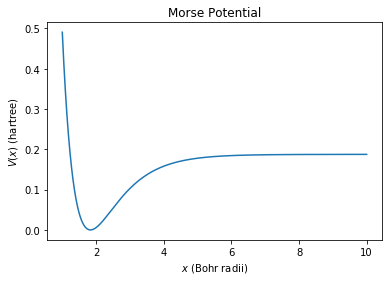

In [2]:
# sanity check that the Morse oscillator looks like as expected
xs = np.linspace(1, 10, 1000)
plt.plot(xs, V(xs))
plt.title(r'Morse Potential')
plt.ylabel(r'$V(x)$ (hartree)')
plt.xlabel(r'$x$ (Bohr radii)')
plt.show()

Now that we have sorted out units and have a function for the Morse oscillator, we can calculate the Hessian. First, the gradient is easily seen to be 
$$
\frac{\partial U_N(\mathbf x)}{\partial x_n} = \frac m{\beta_N^2\hbar^2}(-x_{n+1}+2x_n-x_{n-1}) + \frac{\partial V(x_n)}{\partial x_n}.
$$

Similarly, the Hessian can be calculated, 
$$
\frac{\partial^2 U_N(\mathbf x)}{\partial x_n\partial x_j} = 
\frac m{\beta_N^2\hbar^2}(-\delta_{n+1,j}+2\delta_{n,j}-\delta_{n-1,j})+ 
\delta_{n,j}\frac{\partial^2 V(x_n)}{\partial x_n^2}.
$$
where, as usual, $\delta_{nj}$ is the Kronecker delta function. 

Assuming the Morse potential, it is also easily to calculate the second derivative thereof, via repeated differentiation,
$$
V''(x) = 2D_e\alpha^2e^{-\alpha(x-x_e)}(2e^{-\alpha(x-x_e)}-1).
$$

As described in the question, we are expanding about the bottom of the Morse oscillator, so we evaluate at $x=x_e$ and Taylor expand $U_N(x)\approx\frac {1}{2}x^THx$.

In [3]:
# V''(x) as found above
# we are expanding about the *minimum* => don't need as function
# Vpp(x) = lambda x: 2*De*α*α*np.exp(-α(x-xe))*(2*np.exp(-α*(x-xe))-1)
# Vpp(x_e) = 2Dα²

# assuming room temperature, T=293 K
βr = 1/9.2787578809e-4 # 1/Eh

# TODO do this faster by adding np.eye, etc? If I have time

# I will write the Hessian as a function of N and x
def Hij(i,j,N,β,potential='morse'):
    """
    returns the value of the N by N Hessian matrix ∇U at index i,j
    evaluated at x=x_e (i.e. minimum of Morse potential)
    
    helper function for hessian function, below
    :param: i row index
    :param: j column index
    :param: size of matrix (number of beads)
    :param: β reciprocal temperature
    :param: potential either 'morse' or 'harmonic'
    :return: $H_{ij}$, value of H at index i,j 
    """
    if i==j:
        if potential=='morse':
            return 2*m*N*N/β/β+2*De*α*α
        elif potential=='harmonic':
            return 2*m*N*N/β/β+m*ω*ω
        else:
            print('error: select either morse or harmonic')
    if (i+1)%N==j: # mod N to ensure PBCs
        return -m*N*N/β/β
    if (i-1)%N==j:
        return -m*N*N/β/β
    else:
        return 0

def hessian(N,β,potential='morse'):
    """
    returns the Hessian of size N at reciprocal temp β
    """
    H = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            H[i,j] = Hij(i,j,N,β,potential=potential)
    return H
    
# print small example, looks fine 
print(hessian(4,βr))

[[ 0.5485753  -0.02380566  0.         -0.02380566]
 [-0.02380566  0.5485753  -0.02380566  0.        ]
 [ 0.         -0.02380566  0.5485753  -0.02380566]
 [-0.02380566  0.         -0.02380566  0.5485753 ]]


---

b) Calculate the eigenvalues and eigenvectors of this matrix using 
```
evals, U = numpy.linalg.eigh(H)
```
We use eigh instead of eig because our matrix is hermitian (actually symmetric). If you want, you can check that the eigenvalues are in agreement with the Hückel cyclic alkene formula. The eigenvalues will be stored as a vector and the eigenvectors as a matrix. Show that the eigenvectors are stored in the columns by printing $U^THU$ and checking if the result is the diagonal matrix with the eigenvalues along the diagonal.

---

## Solution

In [4]:
# select some N 
N = 16
H = hessian(N,βr)

evals, U = np.linalg.eigh(H)
UHU = (U.T @ H) @ U # U^THU
# If the following line returns True, then they are the same 
# up to the tolerance
print(np.all(np.abs(UHU-np.diag(evals))<=1e-10))

True


TODO also check the Hückel cyclic alkene formula (not familiar with this -- Look it up!)

TODO I think there is an implicit continuum limit

TODO I am intrigued by how the $U_N$ has a coupling when you start with independent oscillators

---

c) We use the eigenvectors to define a set of normal modes for our system. Check (numerically) that for any path-integral configuration, $\mathbf x$, that $x^THx = \sum_k \lambda_kq_k^2$ where $\lambda_k$ are the eigenvalues and $\mathbf q = U^T(\mathbf x-x_e)$

---

## Solution

Since this is a numerical "proof," I assume that "for any path-integral configuration," we really mean an arbitrary configuration. 

In [5]:
# check for random values between zero and one 

x = np.random.rand(N)

xHx = x.T @ H @ x
print(xHx)

rhs = 0 # rhs of the expression, which should equal xHx
q = U.T @ x
for i in range(N):
    rhs += evals[i] * q[i] * q[i]
print(rhs)

print(abs(xHx-rhs)<=1e-10)

4.383369229506323
4.383369229506323
True


_NOTE:_ I only got this to work by removing the $x_e$ in the definition of $\mathbf q$. I am not sure why $x_e$ is there in the first place.

Just for fun, here is a simple analytical proof. 

We know that $U^THU={\rm diag}\mathbf\lambda$ where $\mathbf \lambda$ is the vector of eigenvalues and ${\rm diag}\mathbf x$ is the matrix with the vector $\mathbf x$ along the diagonal and zeros everywhere else.

Then, by multiplying $U^Tx$ on the right,
$$ 
U^THx = {\rm diag}\mathbf(\lambda) U^Tx
$$
and then by $x^TU$ on the left, 
$$
x^THx = x^TU{\rm diag}\mathbf(\lambda) U^Tx.
$$

But we define $\mathbf q\equiv U^Tx$ so we have 
$$
x^THx = q^T{\rm diag}\mathbf(\lambda) q.
$$

By simple matrix multiplication rules it is then simple to see $x^THx = \sum_k \lambda_kq_k^2$.

TODO check other values when I have time

TODO ask about this (is it a typo?)

---

d) Write code to perform Monte Carlo importance sampling (like in Exercise 2) of the normal-mode coordinates from the distribution
$$
q_k\sim\sqrt{\frac{\beta_N\lambda_k}{2\pi}}e^{-\beta_N\lambda_kq_k^2/2},
$$
and hence compute the partition function at room temperature

_Hint: First converge with respect to the number of Monte Carlo steps (you could estimate the standard deviation in your result to help with this process). Next, converge the results to about 5% error with respect to $N$. You can estimate how many beads will be needed from the condition $\beta_N\hbar\omega_e\ll 1$._

_Hint: use a sanity check to help you eliminate errors, e.g. change the potential V(x) to that of a harmonic oscillator. In this case the normal modes describe the system exactly and each loop of the Monte Carlo algorithm should give exactly the same result with no statistical error._

---

## Solution

First, as a sanity check, it is worth checking that the distribution is properly normalised (I did so via Wolfram Alpha). 

Notice that each $q_k$ has a normal distribution with mean 0 and standard deviation $1/\sqrt{\beta_N\lambda_k}$. 

We have 
$$
\begin{align}
Z(\beta) &= \left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_NU_N(\mathbf x)}\\
&\approx
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_N\frac{1}{2}x^THx}
\\
&=
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_N\frac{1}{2}\sum_k\lambda_kq_k^2}
\\
&=
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x \prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}
\end{align}
$$

From the problem description we sample each $q_k$ from a normal distribution of variance $1/\beta_N\lambda_k$. To do Monte Carlo importance sampling, we first want to express the integrand in terms of the integration variable. 

We have $q=U^Tx$ and thus (by matrix multiplication and remembering to switch the indices due to transposition)
$$
q_k = U_{1k}x_1+...+U_{Nk}x_N.
$$
Hence, taking the partial derivative we have 
$$
\frac{\partial q_k}{\partial x_j} = U_{jk} = (U^T)_{kj}.
$$

Hence, the Jacobian is $U^T$. We have from multivariate calculus, $dq_1dq_2...dq_N=|\frac{\partial(q_1,...,q_N)}{\partial(x_1,...,x_N)}|dx_1dx_2...dx_N$. 

However, 
$$
\begin{aligned}
\left|\frac{\partial(q_1,...,q_N)}{\partial(x_1,...,x_N)}\right| 
&= |U^T|\\
&= |U^{-1}|\\
&= 1/|U| \\
&= 1
\end{aligned}
$$
since the determinant of a unitary matrix is unity. Hence, we have 
$dq_1dq_2...dq_N=dx_1dx_2...dx_N$.

Returning to the partition function, we have 
$$
\begin{align}
Z(\beta) &= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x \prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}\\
&= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} \int{\rm d}\mathbf q\prod_k{\rm e}^{-\beta_N\frac{1}{2}\lambda_kq_k^2}\\
&= 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} 
\left(\int{\rm d}q_1{\rm e}^{-\beta_N\frac{1}{2}\lambda_1q_1^2}\right)
\left(\int{\rm d}q_2{\rm e}^{-\beta_N\frac{1}{2}\lambda_2q_2^2}\right)
\cdot\cdot\cdot
\left(\int{\rm d}q_N{\rm e}^{-\beta_N\frac{1}{2}\lambda_Nq_N^2}\right).
\end{align}
$$

But now each of these integrals is just a gaussian and the solution is known, so we can find the exact/analytical answer. Use $\int e^{-ax^2/2} {\rm d}x = \sqrt{\frac{2\pi}{a}}$:
$$
Z(\beta) = 
\left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2} 
\frac{(2\pi)^{N/2}}{
\beta_N^{N/2}\sqrt{\prod_{k=1}^N \lambda_k}
}
$$
or
$$
Z(\beta) = 
\frac{m^{N/2}}{
\hbar^N\beta_N^{N}\sqrt{\prod_{k=1}^N \lambda_k}
}
$$

In [6]:
# From correspondence with Prof Richardson: 
# The Taylor series may be useful for the derivation,
# but you should look for a numerical result that doesn't actually rely on
# that approximation.
# (I think this resolves the source of my confusion)

# Morse oscillator, defined here again so that I can quickly fiddle with it
# (i.e. change potentials and see how the resulting Z behaves)
# V = lambda xi: De*(1-np.exp(-α*(xi-xe)))**2 
# NOTE what I call xi here is actually x-x_e (!!!)
# V = lambda xi: De*(1-np.exp(-α*xi))**2 

# β_N * U_N (i.e. the term in the exponential)
def potential_U(x, β, potential='morse'):
    """
    U_N (i.e. the term in the exponential)
    
    :param: x vector of positions
    :param: β reciprocal temperature 1/kT
    :return: scalar value in the exponential to be integrated to get Z
    """
    if potential=='morse':
        V = lambda xi: De*(1-np.exp(-α*xi))**2 
    elif potential=='harmonic':
        V = lambda xi: m*ω*ω*xi*xi/2
    else: 
        print('error')
    N = len(x)
    retval = 0
    βN = β/N
    for n in range(N): 
        # NOTE modulo is dealt with since in Python x[-1]==x[N] ☺
#         print('first term', m*N*N*(x[n]-x[n-1])**2/2/β/β)
        retval += m*(x[n]-x[n-1])*(x[n]-x[n-1])/2/βN/βN # hbar = 1
#         print('second term', V(x[n]))
        retval += V(x[n])
    return retval

# integrand up to the constant factor at the front
f = lambda x,β,potential: np.exp(-β/N*potential_U(x,β,potential=potential))

Z: 1.12348e-04 at 300 samples
σ/Z: 5.01722e-02 at 300 samples
wobble: 0
Z: 1.14241e-04 at 600 samples
σ/Z: 3.34543e-02 at 600 samples
wobble: 0
Z: 1.15162e-04 at 848 samples
σ/Z: 2.96891e-02 at 848 samples
wobble: 11


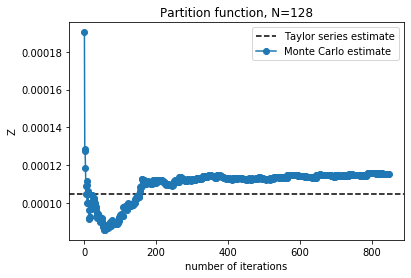

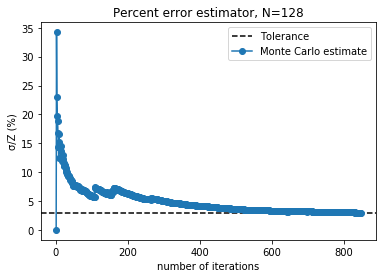

In [7]:
# TODO rename i below

# Monte Carlo Importance Sampling
# from scipy.stats import norm
from scipy.stats import multivariate_normal

def mc_isampling(N, β=1077.73, potential='morse', max_samples=3000, verbose=False, taylor_estimate=True):
    """
    performs Monte Carlo importance sampling to calculate the partition
    function given in the exercise, for N beads
    
    all parameters are in atomic hartree units
    
    :param: N number of beads
    :param: β inverse temperature 1/kT (default room temp)
    :param: max_samples maximum samples, in case it does not converge
    :param: verbose (T/F) whether or not to print and plot results
    :param: taylor_estimate (T/F) whether or not to include Taylor estimate
    :return: Z the partition function, at different # of samples
    :return: σ_pct the estimated percentage error
    """
#     max_samples = 1000 # number of samples (L)
    Z = np.zeros((max_samples,)) # keep track of Z as we sample
    σ = np.zeros((max_samples,)) # error estimate
    # for now, assuming room temperature, T=293 K
    fis = np.zeros((max_samples,))

    # set up with hessian to get U 
    H = hessian(N,β,potential=potential)
    evals, U = np.linalg.eigh(H)

    # TODO this prefactor blows up for large N
    prefac = (m*N/(2*pi*β))**(N/2)
#     print('Prefactor is set to 1')
    # print(prefac)
    i=0
    wobble=0 # keep track of how many times it is below 
    max_wobble=10 # stay below tol_pct max_wobble times
    tol_pct=0.03 # 1% error tolerance
    # for i in range(max_samples):
    while wobble<=max_wobble and i<max_samples:
        # sigma * np.random.randn(...) + mu
        variance = N/β/evals
        # sample q, q_i ~ N(0,σ_i)
        q = np.sqrt(variance) * np.random.randn(N) # + 0
        # assuming q_i's are indep, so covariance matrix is diagonal
        covar = np.diag(variance) # covar for q's
        x = U @ q    
        # use Affine transformation of multivariate normal distro
        # cov = U*cov*U.T
        w = multivariate_normal.pdf(x, mean=np.zeros((N,)), cov=U@covar@U.T)
        fis[i] = prefac*f(x,β,potential)/w
        Z[i] = np.sum(fis)/(i+1)
        σ[i] = (1/(i+1)**2)*np.sum(fis*fis)-(1/(i+1))*(np.sum(fis)/(i+1))**2
        σ[i] = np.sqrt(σ[i])
        # print results every 10% of max_samples
        if (i+1) % (max_samples//10) == 0 and verbose:
            print('Z: %.5e at %i samples' % (Z[i],(i+1)))
            print('σ/Z: %.5e at %i samples' % (σ[i]/Z[i], i+1))
            print('wobble:',wobble)
    #     Σ += fi
    #     σ += fi*fi
    #     print('Σ/N: %.4e' % (Σ/(i+1)))
        wobble=wobble+1 if σ[i]/Z[i]<tol_pct else 0
        i=i+1
    if verbose:
        print('Z: %.5e at %i samples' % (Z[i-1],i))
        print('σ/Z: %.5e at %i samples' % (σ[i-1]/Z[i-1], i))
        print('wobble:',wobble)
    Z = Z[:i-1]
    σ = σ[:i-1]

    if verbose:
        # while this uses more approximations, it should give an estimate
        # overflow error for lage N though, had to
        # rewrite in a while that will make it work
        if taylor_estimate:
            estimateZ = m**(N/2)/((β/N)**N*np.sqrt(np.prod(evals)))

            plt.axhline(y=estimateZ, color='k', linestyle='--',label='Taylor series estimate')
        plt.plot(np.arange(1,i,1),Z,'o-',label='Monte Carlo estimate')
        plt.title('Partition function, N=%i'%N)
        plt.xlabel('number of iterations')
        plt.ylabel('Z')
        plt.legend()
        plt.show()

#         if taylor_estimate:
        plt.axhline(y=100*tol_pct, color='k', linestyle='--',label='Tolerance')
        plt.plot(np.arange(1,i,1),100*σ/Z,'o-',label='Monte Carlo estimate')
        plt.legend()
        plt.title('Percent error estimator, N=%i'%N)
        plt.xlabel('number of iterations')
        plt.ylabel('σ/Z (%)')
        plt.show()
    return Z, σ/Z

# NOTE for large N, the prefactor is very large as it goes like x^N/2
# and the exponential is very small because it goes like e^(-N)
# so the computer does not handle it well (get numerical errors)
# TODO while this works for sufficiently large N, to get 5% error as 
# required, maybe use the mpmath package to go even higher 
# (or find a way to re-express the integral)
N = 128 # number of beads (to be adjusted)
# β = 1077.73 # 1/Eh
# don't include the Taylor estimate for big N (it blows up, some numerical issue)
mc_isampling(N, verbose=True, taylor_estimate=True);

N estimate: 183.49445834227265
Z: 1.21129e-04 at 300 samples
σ/Z: 5.58985e-02 at 300 samples
wobble: 0
Z: 1.17633e-04 at 600 samples
σ/Z: 4.92253e-02 at 600 samples
wobble: 0
Z: 1.13757e-04 at 900 samples
σ/Z: 3.65309e-02 at 900 samples
wobble: 0
Z: 1.14945e-04 at 1181 samples
σ/Z: 2.97935e-02 at 1181 samples
wobble: 11


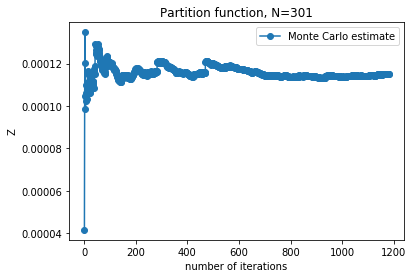

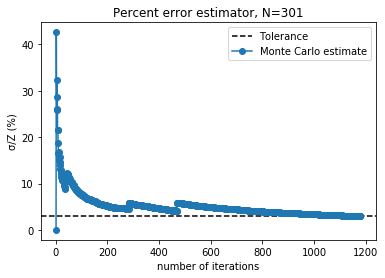

percent error wrt N: -4.73663e+02 at N=1
percent error wrt N: -1.08089e+00 at N=11
percent error wrt N: -2.86166e-01 at N=21
percent error wrt N: -1.24850e-01 at N=31
percent error wrt N: -7.31873e-02 at N=41
percent error wrt N: -3.60209e-02 at N=51
percent error wrt N: -5.70359e-03 at N=61


In [8]:
# check convergence wrt N
# N = 1
# Ns = 1,2,4,..2^lenN
# print(lenN)
# print(Ns)
# lenN = 7
print('N estimate:',10*1077.73*ω)
Ns = np.arange(1,301+1,10)#2**np.arange(0,lenN+1,1)
# print(Ns)
lenN = len(Ns)
# print(Ns)
tol_pct = 0.05 # 5% tolerance

# # # first, get the "true" result
# print(Ns[-1])
N = Ns[-1]
Z_true,σ_pct_true = mc_isampling(N, verbose=True, taylor_estimate=False)

# print('Z',Z_true)
# print('σ%',σ_pct_true)

# # maxN = 256 # maximum N
wobble = 0
max_wobble = 1 # need at least max_wobble+1 in a row
Z_wrtN = np.zeros((lenN,))
σ_pct_N = np.zeros((lenN,))
# # Zs_N = [] # Zs wrt N
# # for i,N in reversed(list(enumerate(Ns))):
for i,N in enumerate(Ns[:-1]): # exclude the last one
    Z,σ_pct = mc_isampling(N, verbose=False, taylor_estimate=False)
    σ_pct_N[i] = (Z_true[-1]-Z[-1])/Z_true[-1]
    Z_wrtN[i] = Z[-1]
    print('percent error wrt N: %.5e at N=%i' % (σ_pct_N[i],N))
    wobble=wobble+1 if abs(σ_pct_N[i])<tol_pct else 0
    if wobble>max_wobble:
        break
# print(σ_pct_N)

TODO "converge the result to about 5% error with respect to N." Not really sure what this means.

TODO what is the significance of the condition given in the first hint? 

TODO why do we sample on $q$ instead of $x$? 

TODO I think what I have as $x$ is actually $x-x_e$...
- perhaps email Prof Richardson yet again (I think he was right the first time; i.e. no typo)
- fix this in the previous question as well. I used $x-x_e$ but didn't realise I renamed it to just $x$ because I kept just $x$ instead of $x-x_e$ in the Taylor expansion.
- I think he *does* have a typo when he writes out the Taylor expansion, but not when he writes the definition of $q$. 

TODO https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation

TODO implement the other convergence criteria

TODO use an exact solution like the harmonic oscillator as a sanity check

TODO turn the above code into a function so that I can easily call it in subsequent sections

---

e) Look up the Morse-oscillator energy levels and compute the quantum partition function in the standard way to check that your path-integral result is in agreement. Also compute the classical partition function using quadrature. 

---

## Solution

From many sources, (e.g. Wikipedia, https://arxiv.org/pdf/quant-ph/0411159.pdf, https://demonstrations.wolfram.com/EnergyLevelsOfAMorseOscillator/, https://scipython.com/blog/the-morse-oscillator/)
$$
E_n = \hbar\omega_e(n+1/2)-\hbar\omega_e\chi_e(n+1/2)^2
$$

with $n=0,1,2,...\lfloor 2D_e/\omega_e\rfloor$. 

TODO Not exactly sure what is meant by "the standard way." Do we mean just summing over $e^{-\beta E_j}$?

$$
{\rm Tr}e^{-\beta H}
$$

TODO

First, let's calculate the the partition function from the Morse oscillator energy levels. 

In [9]:
# from math import factorial

β = 1077.73 # room temp
def Z_QM(β):
    En = lambda n: ω*(n+1/2)-ω*χ*(n+1/2)**2
    n=0
    newZ = 0
    while n<2*De/ω: # == np.sqrt(2*m*De)/α
        newZ += np.exp(-β*En(n))
    #     print(newZ)
        n+=1
    return newZ
# newZ /= factorial(N) # indistinguishability

# they are close but not exactly in agreement
# I suspect I may have made a mistake somewhere
newZ = Z_QM(β)
print(newZ)
print(Z_true[-1])

0.00011500347121643913
0.00011495727572820548


Next, let's calculate the classical partition function using quadrature. 

TODO show work for how to get here, 
$$
Z_{\rm classical} = \left(\frac{m}{2\pi\beta\hbar^2}\right)^{1/2}I(x)
$$
where 
$$
I(x) \equiv \int{\rm d}x e^{-D_e\beta(1-e^{-\alpha(x-x_e)})^2}.
$$

So numerically integrate $I(x)$ and then plug into the equation above. 

For ease of implementation, we can make the change of variables $x-x_e\to x$:
$$
I(x) = \int{\rm d}x e^{-D_e\beta(1-e^{-\alpha x})^2}.
$$

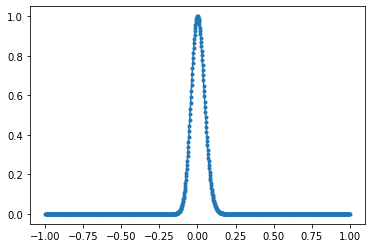

In [10]:
from scipy.integrate import quad

# N = 1 # TODO change this
β = 1077.73 # room temp

def integrand(x, β):
    retval = -De*β*(1-np.exp(-α*x))**2
    return np.exp(retval)

# view integrand -- can see it's extremely sharply peaked
# => consider only a small interval around zero
# tested a few intervals and saw this is good enough
tmpx = np.linspace(-1, 1, 1000)
plt.plot(tmpx, integrand(tmpx,β), '.-')
plt.show()

# def Z_CM(N,β):
def Z_CM(β):
    # TODO test
    I_inZ = quad(lambda x: integrand(x,β), -1, 1)[0]
#     return (m/(2*pi*β))**(N/2)*I_inZ**N
    return np.sqrt(m/(2*pi*β))*I_inZ

# I_inZ = quad(lambda x: integrand(x,β), -np.inf, np.inf)
# Ns = np.arange(1,301+1,10)
# for i in range(len(Ns)):
    N=Ns[i]
#     I_inZ = quad(lambda x: integrand(x,β), -1, 1)[0]
#     print(I_inZ)

# (m*N/(2*pi*β))**(N/2)
    # it very quickly approaches zero
    Z_class = Z_CM(β) # (m/(2*pi*β))**(N/2)*I_inZ**N
#     print(Z_class)
    print('Z_class=%.5e for N=%i' % (Z_class, Ns[i]))
# TODO 
# print('stub')
# print(Z_wrtN)
# print(np.arange(1,301+1,10))

---

f) Plot $Z$ against (a few values of) $\beta$ for quantum, classical and path-integral approaches with various values of $N$, e.g. $N=1,2,4,8,16,...$ until convergence. In what limits are the $N=1$ results acceptable?

---

## Solution

TODO seems like these simulations will take a long time. 

TODO not sure how to distinguish between quantum, classical, and path-integral approaches...
I guess by these terms he means: 
- quantum is just a sum of Boltzmann factors.
- classical is the classical partition function (i.e. integral). 
- path integral is just plugging into what was given in the question, Z(β). 

TODO it seems like the quantum case is broken for low temp??

Ts
[  10.           16.68100537   27.82559402   46.41588834   77.42636827
  129.1549665   215.443469    359.38136638  599.48425032 1000.        ]
N=1
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [0.00185544 0.00309914 0.00516664 0.00856893 0.01464646 0.02454705
 0.04185548 0.06655425 0.11251449 0.18085736]


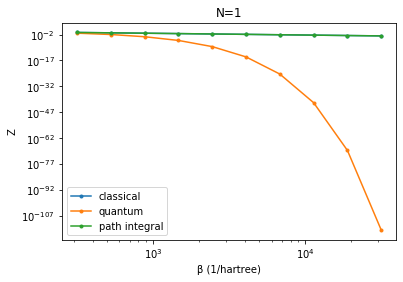

N=2
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [1.37196866e-05 3.82047112e-05 1.04970718e-04 2.88673900e-04
 8.05079653e-04 2.22350677e-03 6.24167628e-03 1.76456932e-02
 4.54719207e-02 1.02977863e-01]


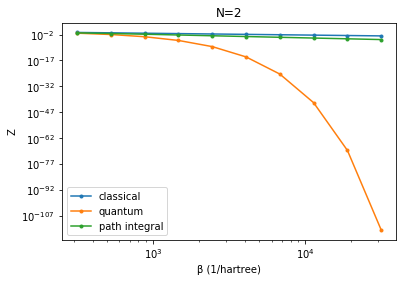

N=4
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [3.20041315e-09 2.41425857e-08 1.80867329e-07 1.47400378e-06
 1.06324833e-05 8.74883677e-05 6.29074084e-04 4.06041519e-03
 2.24315207e-02 8.14600915e-02]


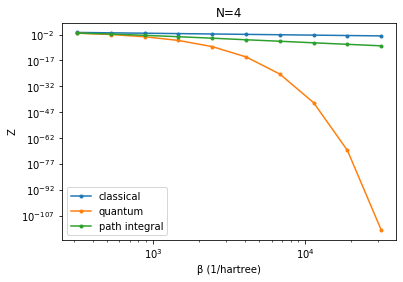

N=8
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [2.39197558e-15 1.39933319e-13 8.48988919e-12 5.04800665e-10
 2.88990875e-08 1.47325770e-06 5.98417545e-05 1.36506224e-03
 1.51081725e-02 7.06936064e-02]


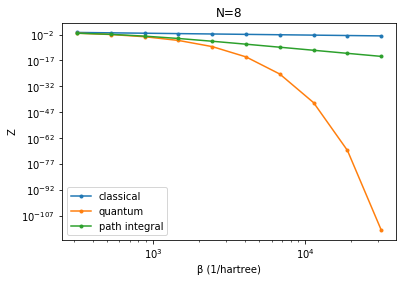

N=16
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [3.72499225e-25 1.33160201e-21 4.82906932e-18 1.47731167e-14
 3.28173518e-11 3.61777595e-08 1.14104682e-05 7.39896495e-04
 1.20632042e-02 6.75989406e-02]


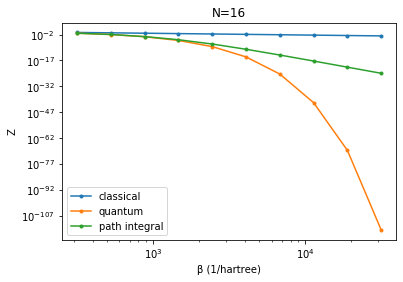

N=32
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [5.86542072e-40 6.72425138e-33 5.27545032e-26 1.89584333e-19
 1.34790877e-13 4.12956855e-09 5.94092285e-06 6.48269908e-04
 1.20070367e-02 6.79057577e-02]


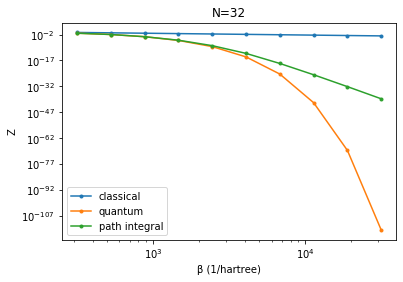

N=64
Z_c [0.00186014 0.00310308 0.00517673 0.00863667 0.01441062 0.02404892
 0.04014548 0.06704918 0.11207661 0.18761128]
Z_q [3.79123952e-116 6.40910211e-070 3.30951754e-042 1.35910256e-025
 1.23815882e-015 1.15705555e-009 4.39158808e-006 6.14237458e-004
 1.18779414e-002 7.05283203e-002]
Z_p [3.65690545e-60 1.73602733e-46 7.99552303e-34 4.31106650e-23
 6.11637576e-15 1.63785945e-09 4.86771793e-06 6.27385580e-04
 1.21390430e-02 7.20136269e-02]


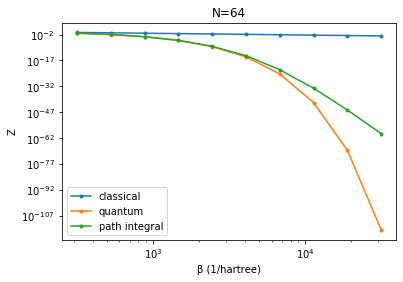

In [11]:
# βs = np.linspace(0,3000,10) # 1/hartree
# high temp (~3e5 K), room temp, small temp (~1 K)
# TODO test more values
# βs = [1, 1077.73, 300000] # 1/hartree

kB = 3.1668115635e-6 # E_h/K
Ts = np.logspace(1,3,10)
βs = 1/(Ts*kB)
print('Ts')
print(Ts)
Ns = 2**np.arange(0,7,1) # up to 64
lenN = len(Ns)
Z_q = np.zeros((len(βs),))
for i,β in enumerate(βs):
    # QM (does not require N)
    Z_qi = Z_QM(β)
    Z_q[i] = Z_qi
    
for j,N in enumerate(Ns): 
    Z_p = np.zeros((len(βs),))
    Z_c = np.zeros((len(βs),))
    for i,β in enumerate(βs):
#         print('T=%.5e' % Ts[i])
        # path integral
        Z_pi,σ_pct_pi = mc_isampling(N, β=β, verbose=False, taylor_estimate=True)
        # classical
        Z_ci = Z_CM(β)
        Z_p[i] = Z_pi[-1]
        Z_c[i] = Z_ci
    # I'm printing out values to compare them, since the values change
    # so much with temp that it may be hard to read from the graph
    print('N=%i'%N)
    print('Z_c', Z_c)
    print('Z_q', Z_q)
    print('Z_p', Z_p)
    plt.plot(βs,Z_c,'.-',label='classical')
    plt.plot(βs,Z_q,'.-',label='quantum')
    plt.plot(βs,Z_p,'.-',label='path integral')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.title('N=%i' % N)
    plt.ylabel('Z')
    plt.xlabel('β (1/hartree)')
#     plt.xlabel('T (K)')
    plt.show()

$N=1$ results are acceptable in the high-$T$ limit. It seems the path-integral approach agrees with the classical case for small $N$ and approaches the quantum case for large $N$. 

---

g) Also consider the harmonic-oscillator approximation. Put these approximations in the order of how accurately they predict the correct partition function: 
- quantum harmonic oscillator, 
- classical harmonic oscillator, 
- large but finite $N$ path-integral calculation of the harmonic oscillator, 
- classical Morse oscillator, 
- large but finite $N$ path-integral calculation of the Morse oscillator. 

The real advantage of the path-integral method is that it can be easily applied to more complicated problems than the Morse oscillator, including high-dimensional systems, without needing to sovle the Schrödinger equation at all.

---

## Solution

TODO explain the values below, i.e. do some derivations 

$$
V(x) = \frac{1}{2}m\omega^2(x-x_e)^2
$$

The quantum Morse oscillator should be the best approximation since we are dealing with unbound states. The rest can be checked with numerics, but in general I suspect the quantum case to be the best, then path integral, then classical, and in general Morse to be more accurate than harmonic oscillator. I will check the values for each at room temperature. 

Z: 1.10299e-04 at 300 samples
σ/Z: 5.79672e-02 at 300 samples
wobble: 0
Z: 1.10968e-04 at 600 samples
σ/Z: 3.69074e-02 at 600 samples
wobble: 0
Z: 1.12732e-04 at 828 samples
σ/Z: 2.96583e-02 at 828 samples
wobble: 11


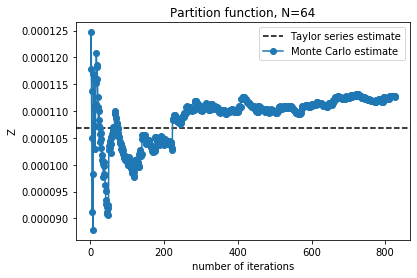

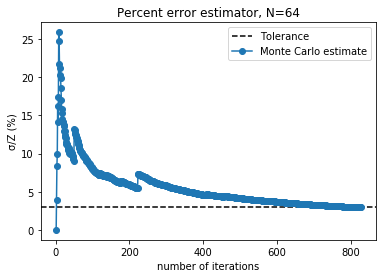

In [12]:
N = 64
β = 1077.73 # room temp
Z_morse_path, _ = mc_isampling(N, β=β, potential='morse',verbose=True)
Z_harm_path, _ = mc_isampling(N, β=β, potential='harmonic',verbose=False) # all fall on same spot, not exciting
# good to see that the Taylor approximation works nicely also for the harmonic case though
Z_morse_qm = Z_QM(β)
Z_morse_cm = Z_CM(β)
# now just need classical and quantum harmonic oscillators
# they are both exactly solved!
from math import sinh
Z_harm_qm = 1/(2*sinh(β*ω/2)) # **N
Z_harm_cm = 1/(β*ω) # **N

In [13]:
print('Morse:')
print('\tQM: Z=%.5e; %% error=0' % Z_morse_qm)
print('\tPath: Z=%.5e, %% error=%.5e' % (Z_morse_path[-1], (Z_morse_qm-Z_morse_path[-1])/Z_morse_qm))
print('\tCM: Z=%.5e, %% error=%.5e' % (Z_morse_cm, (Z_morse_qm-Z_morse_cm)/Z_morse_qm))

print('Harmonic:')
print('\tQM: Z=%.5e, %% error=%.5e' % (Z_harm_qm, (Z_morse_qm-Z_harm_qm)/Z_morse_qm))
print('\tPath: Z=%.5e, %% error=%.5e' % (Z_harm_path[-1], (Z_morse_qm-Z_harm_path[-1])/Z_morse_qm))
print('\tCM: Z=%.5e, %% error=%.5e' % (Z_harm_cm, (Z_morse_qm-Z_harm_cm)/Z_morse_qm))

Morse:
	QM: Z=1.15003e-04; % error=0
	Path: Z=1.12797e-04, % error=1.91894e-02
	CM: Z=5.46335e-02, % error=-4.74059e+02
Harmonic:
	QM: Z=1.03626e-04, % error=9.89321e-02
	Path: Z=1.06903e-04, % error=7.04339e-02
	CM: Z=5.44976e-02, % error=-4.72878e+02


The above shows, at least for room temperature, that the order from most to least accurate is: 
 - Quantum Morse oscillator 
 - Path-integral Morse oscillator
 - Path-integral harmonic oscillator
 - Quantum harmonic oscillator
 - Classical harmonic oscillator
 - Classical Morse oscillator
 
Though of course this will also depend on temperature. The two classical approximations are very similar (and both far from the true value), so distinguishing between them is perhaps not very meaningful. In theory, I would expect the classical Morse oscillator in better, but it seems to not make much difference. 

---

TODO remember to also write a motivation letter

TODO how is this a path integral? Looks more like standard quantum statistical mechanics to me...